In [2]:
!pip install PrettyMidi

  Could not find a version that satisfies the requirement PrettyMidi (from versions: )
No matching distribution found for PrettyMidi
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import PrettyMidi.pretty_midi as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

ModuleNotFoundError: No module named 'PrettyMidi'

In [2]:
music1 = pm.PrettyMIDI("Piano Sonata n14 op27 1mov ''Moonlight''.mid", initial_tempo=49, ignore_tempo_changes=True)

In [3]:
music1.get_piano_roll().shape

(128, 33795)

In [4]:
music1.get_tempo_changes()

(array([0.]), array([49.]))

In [5]:
for instrument in music1.instruments:
    print(instrument.name)

PIano right second
Piano left
Piano right first


In [6]:
piano = music1.instruments[0]

In [7]:
pianoRoll = piano.get_piano_roll()


Let's try to convert this into a time series.

In [8]:
piano_df = pd.DataFrame(pianoRoll)

In [9]:
def get_nonzero_idx(col):
    """
    col is a pd.Series
    """
    return col.index.to_series()[col!=0].values

In [10]:
series = []
for cl in piano_df.columns:
    series.append(get_nonzero_idx(piano_df[cl]))

In [33]:
def collapse(series):
    output = []
    # loop through each value, store new value only when new values != old value
    oldVal = None
    for value in series:
        # For case when value is of length 1
        if len(value) == 1:
            # If any number in new vector is not in old vector, append the new number
            if np.any(value != oldVal):
                output.append(value[0])
                # replace oldVal with new val so that if the new val repeats
                # it will not get appended
                oldVal = value
            else:
                continue
        elif len(value) == 2:
            # Basic idea is the same
            # Find the element in the vector that is not in the old vector
            # and append it
            # there is no case when the new vector will be of length > 1
            # and the old vector is also len>1 and thus have more than 1
            # new numbers to append at least in this piece
            if np.any(value != oldVal):
                to_append = np.array([val for val in value if val not in oldVal])
                output.append(to_append[0])
                oldVal = value
            else:
                continue
        else:
            continue
    return output

In [31]:
tseries = collapse(series)

In [37]:
# Check if there are any 3 consecutive numbers that are consecutive

results = []
for i in range(801-3):
    results.append(len(tseries[i:i+3]) != len(set(tseries[i:i+3])))

In [41]:
sum(results)

33

There are 33 instances of repeating notes in a 3 note sequence - not very different from expectations as the piece goes mostly in three note phrases that form a chord.

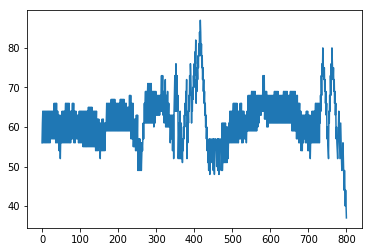

In [42]:
plt.plot(tseries)